# 5-Minute Craft Youtube Video Titles

Team members: Douglas Greaves, Julio Oliveira, Satoshi Taniguchi

Data Source: https://www.kaggle.com/shivamb/5minute-crafts-video-views-dataset

This notebook aims to explore characterists and generate insights from video titles of the Youtube channel [5-Minute Crafts](https://www.youtube.com/channel/UC295-Dw_tDNtZXFeAPAW6Aw) 

In [22]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.display.float_format = '{:.2f}'.format

## Exploring the Dataset

In [2]:
df = pd.read_csv('../data/external/5-Minute Crafts.csv')

The dataset consists of the video_id, title, and some previously calculated metrics.

In [3]:
df.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=lCePSP4lb-k,Wow! Let's go live! Epic decorations and DIYS,1,558,10825,45,8,3,1,4,1,5.62,0,0,0.13
1,v=G7O9iWWOtTY,EXTREME ROOM TRANSFORMATION || Cool Design Ide...,1,1020,184374,63,10,2,3,0,2,6.30,0,0,0.11
2,v=cd0u5IFxBdo,LATE SUMMER HACKS TO SAVE YOUR DAY,2,629,478170,34,7,0,7,0,2,4.86,0,0,-0.30
3,v=lWSXHFPqBfo,EVERY SMART PARENT KNOWS THESE USEFUL HACKS #s...,2,41,197359,51,8,1,7,1,1,6.38,0,0,0.26
4,v=qqPFeyd84Lg,SMART HACKS TO SAVE YOUR WEDDING DAY🤵‍👰‍💍🕊️,3,784,162025,43,7,0,7,0,2,6.14,0,0,0.21


Total number of rows and columns:

In [4]:
df.shape

(4904, 15)

Checking the video ids we can confirm that all videos are unique.

In [5]:
len(df.video_id.unique())

4904

Altought all videos ids are unique, a small amount of video titles repeats.

In [6]:
len(df.title.unique())

4892

The dataset does not have any null values

In [7]:
df.isnull().values.any()

False

Lets check some descriptive statistics about the videos:

* Altough the channel is called 5-minutes, 96% of the videos have a duration higher than 6 minutes, and 75% more than 11 minutes.
* The channel has a video with over 280M views. 75% of the videos have more than 567K views.
* The mean number of words is 8 on the video title.
* The average word lenght is 5.46 wich is close to average lenght of english words of 5.1 according to [WolframAlpha](https://www.wolframalpha.com/input/?i=average+english+word+length)
* 93% of their videos have a digit in the title

In [8]:
df[['duration_seconds', 'total_views', 'num_words','avg_word_len', 'contain_digits']].describe()

,duration_seconds,total_views,num_words,avg_word_len,contain_digits
count,4904.00,4904.00,4904.00,4904.00,4904.00
mean,930.06,4331058.66,8.20,5.46,0.93
std,720.27,9706409.31,2.51,0.66,0.26
min,27.00,4034.00,3.00,3.67,0.00
25%,697.00,567791.00,6.00,5.00,1.00
50%,866.00,1459397.00,8.00,5.38,1.00
75%,960.00,4298147.50,10.00,5.80,1.00
max,14880.00,283031109.00,20.00,10.00,1.00


In [9]:
df[df.duration_seconds > 360].shape[0] / df.shape[0]

0.9563621533442088

## Distribution

Evaluating the distribution of active days since, we can notice that the dataset does not provide exact dates for when the video was published. This happens possibily because of how Youtube shows on its page the time since the video was published.

The number of videos with 'active days since' less than 365 is very small. Comparing those videos with olders, may be misleading, for this reason we drop them from the dataset.

[Text(0.5, 0, 'Active days since'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Accumalated distribution of Active days since')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


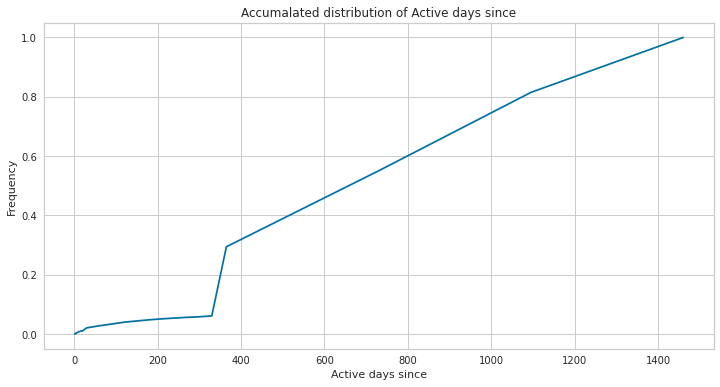

In [10]:
accumulated_percent = df.active_since_days.value_counts().sort_index() / df.active_since_days.count()
accumulated_percent = accumulated_percent.cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(accumulated_percent.index, accumulated_percent)
ax.set(xlabel="Active days since",
       ylabel="Frequency",
       title="Accumalated distribution of Active days since")

In [11]:
accumulated_percent

1      0.00
2      0.00
3      0.00
4      0.00
5      0.00
6      0.00
10     0.01
15     0.01
20     0.01
30     0.02
60     0.03
90     0.03
120    0.04
150    0.04
180    0.05
210    0.05
240    0.05
270    0.06
300    0.06
330    0.06
365    0.29
730    0.55
1095   0.81
1460   1.00
Name: active_since_days, dtype: float64

In [12]:
df = df[df.active_since_days >= 365]
df.shape

(4603, 15)

We first expected that older videos would have higher total views, however looking into the box plot of 'Total Views x 'Active Days Since', there is no clear distiction between those groups. This can be related to many reasons, one of them being the subscribers growth rate of the channel overtime.

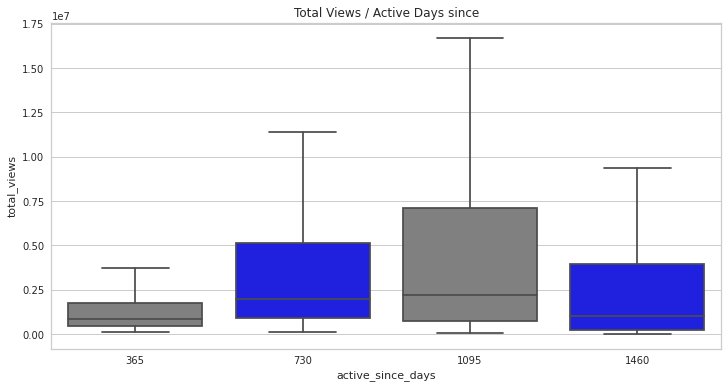

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="active_since_days", y="total_views",
                 data=df, ax = ax, palette=['gray','blue'], showfliers=False)

As we noticed in the descriptive statistcs of the dataset the distribution of videos duration skewed to the right.

[Text(0.5, 0, 'Duration seconds'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of duration seconds')]

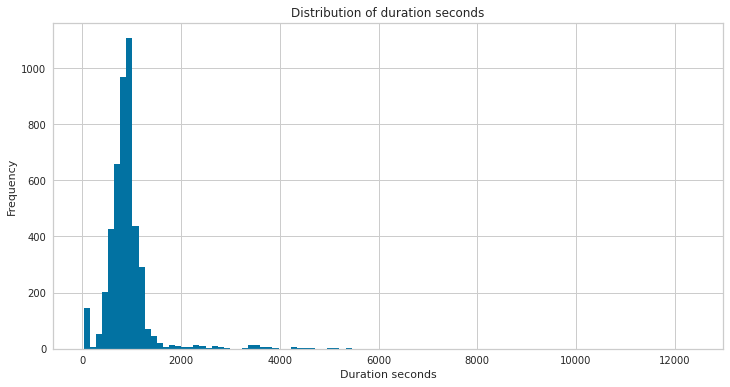

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df.duration_seconds, bins=100)
ax.set(xlabel="Duration seconds",
       ylabel="Frequency",
       title="Distribution of duration seconds")

In [15]:
df.reset_index(inplace=True, drop=True)

## Feature Engineering

The features 'num_words_uppercase' and 'num_words_lowercase' are very similar to each other, for this reason we deleted them and created a feature called represint the percentual of uppercase words, given the total of words in the title.

In [16]:
df['perc_uppercase'] = df.num_words_uppercase / df.num_words
df.drop(['num_words_uppercase','num_words_lowercase'],axis=1, inplace=True)

In [17]:
original_features = df.columns

To evaluate the **relevance** of the words used in the titles, we removed the stopwords and calculated the TF-IDF(term frequency weighted by inverse document frequency).

In [18]:
df['title'] = df.title.str.lower()

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r"\b[^\d\W]+\b")


[nltk_data] Downloading package stopwords to /home/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
sdf = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(df.title),
                         columns=vectorizer.get_feature_names_out())
df = df.join(sdf)

## Clustering



In [20]:
X = df[['active_since_days', 'duration_seconds','total_views']].copy()
X = StandardScaler().fit_transform(X)

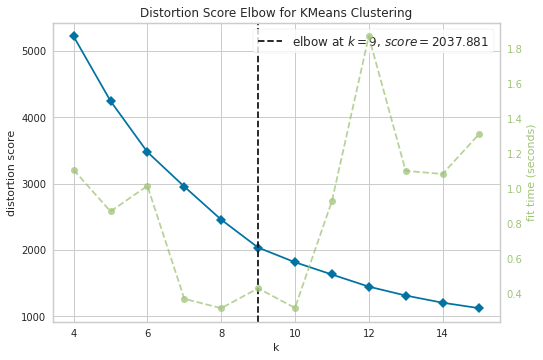

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(4,16))
elbow.fit(X)
elbow.show()

In [24]:
# Uncoment the lines below for retraining the model. 
# Attention, the cluster names steps below will need to be renamed. 

# kmeans = KMeans(elbow.elbow_value_)
# kmeans.fit(X)

# with open('../models/kmeans.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)

with open('../models/kmeans.pkl', 'rb') as file:
    kmeans = pickle.load(file)

In [25]:
df['cluster'] = kmeans.predict(X)
df.cluster.value_counts()

/tmp/ipykernel_14143/1531709052.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = kmeans.predict(X)


7    1120
2    1109
0    1080
5     812
8     295
4     113
1      61
3       8
6       5
Name: cluster, dtype: int64

In [23]:
MIN_LEN = 100

clusters_len = df.cluster.value_counts().sort_index()

clusters_filter = {i for i,value in enumerate(clusters_len) if value > MIN_LEN}
clusters_filter

{0, 1, 4, 5, 6, 8}

cols_weight = ['total_views','active_since_days']
p = 4

for col in cols_weight:
    index = list(df.columns).index(col) - len(cols_to_drop)
    X[:,index] *= p 

In [24]:
filtered_clusters = df[df.cluster.isin(clusters_filter)].copy()

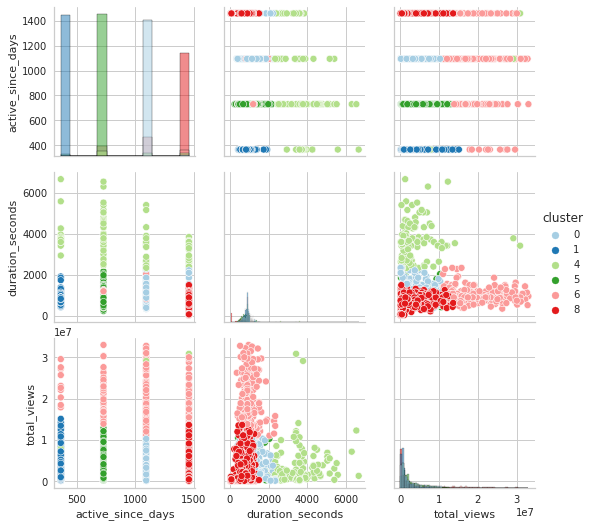

In [25]:
cols_to_plot = ['active_since_days', 'duration_seconds',
       'total_views', 'cluster']

g = sns.PairGrid(filtered_clusters[cols_to_plot], hue="cluster", palette="Paired")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [29]:
cluster_names = {
    0: '3 years ',
    1: '1 years',
    4: 'Long duration',
    5: '2 years',
    6: 'Top performers',
    8: '4 years'
}

filtered_clusters['cluster_name'] = df.cluster.map(cluster_names)

/tmp/ipykernel_3737/3124269584.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_clusters['cluster_name'] = df.cluster.map(cluster_names)


### Clusters names
* **0**: 4 years videos
* **1**: 2 years videos
* **2**: Long duration videos
* **5**: 1 year videos
* **7**: Top performers
* **8**: 3 years videos 

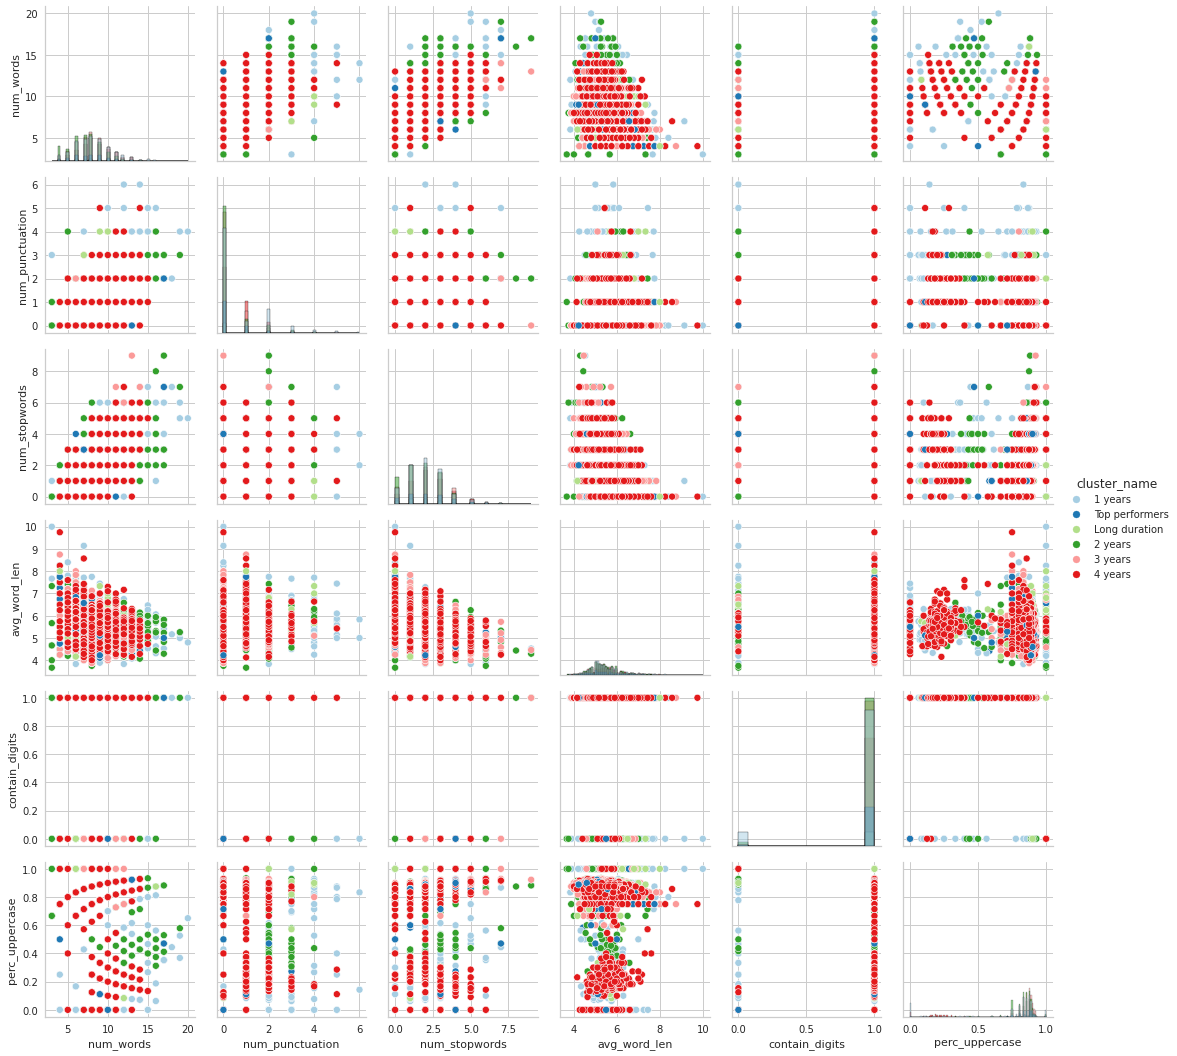

In [31]:
cols_to_plot = ['num_words', 'num_punctuation',
       'num_stopwords', 'avg_word_len', 'contain_digits',
       'perc_uppercase', 'cluster_name']

g = sns.PairGrid(filtered_clusters[cols_to_plot], hue="cluster_name", palette='Paired')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Insights
1 year videos: more words, more punctuation
3 years videos: more uppercase words
4 years digits: more titles containing digits
Top performers: less punctuation

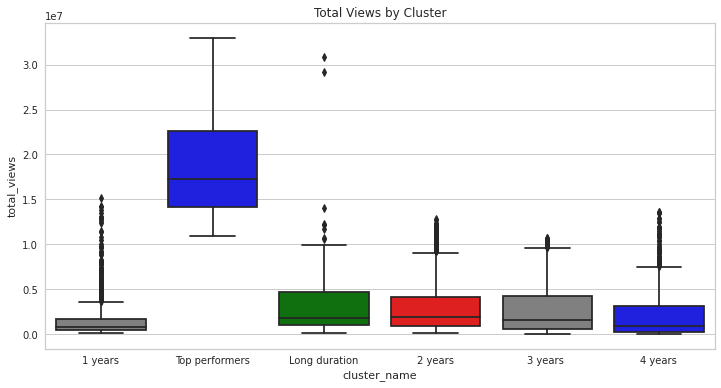

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views by Cluster")

ax = sns.boxplot(x="cluster_name", y="total_views",
                 data=filtered_clusters, ax = ax, palette=['gray','blue','green','red'])

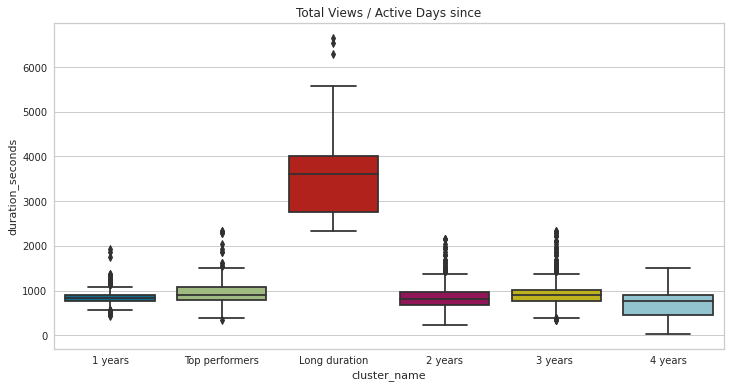

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Cluster",
       ylabel="Duration Seconds",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="cluster_name", y="duration_seconds",
                 data=filtered_clusters, ax = ax)

In [59]:
cols_to_drop = list(original_features)+['cluster_name', 'cluster']
for c in sorted(filtered_clusters.cluster_name.unique()):
    print(f'Evaluating most relevant words for each cluster: {c}')
    cluster_data = filtered_clusters[filtered_clusters.cluster_name == c].copy()
    cluster_data = cluster_data.drop(cols_to_drop, axis=1)
    print(cluster_data.mean().sort_values()[-10::])
    print('---------------\n')


Evaluating most relevant words for each cluster: 1 years
know      0.023912
crazy     0.025025
cool      0.025779
home      0.027134
try       0.029522
life      0.030718
tricks    0.031715
diy       0.036125
ideas     0.063535
hacks     0.066392
dtype: float64
---------------

Evaluating most relevant words for each cluster: 2 years
easy      0.024028
make      0.024233
cool      0.024931
know      0.026009
tricks    0.028031
beauty    0.028753
crazy     0.037263
ideas     0.037604
life      0.053415
hacks     0.103511
dtype: float64
---------------

Evaluating most relevant words for each cluster: 3 years 
try       0.020511
ideas     0.020927
cool      0.022210
tips      0.024106
make      0.024958
know      0.025444
tricks    0.027431
easy      0.029997
life      0.054715
hacks     0.089376
dtype: float64
---------------

Evaluating most relevant words for each cluster: 4 years
tricks    0.023398
know      0.023878
ways      0.027113
tips      0.028614
make      0.030479
life      

* Long duration shows words like: "Live", "Compilation" as relevant
* Comparing 4 years to 1 year: "craft" and "minute" used to the most relevants words in the title, what changed in the 1 years videos.

[Text(0.5, 0, 'Duration seconds'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Accumalated distribution of duration')]

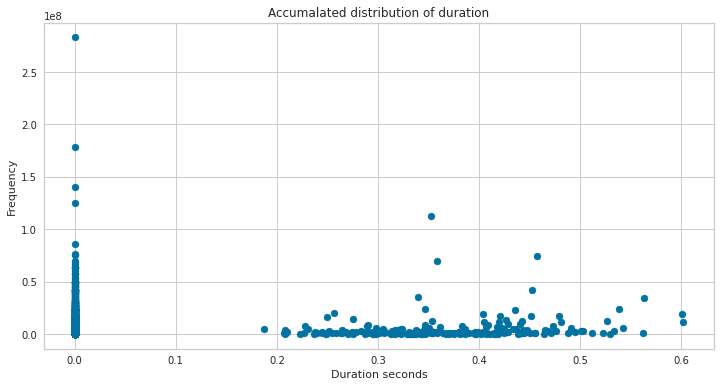

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df.simple, df.total_views)
ax.set(xlabel="Duration seconds",
       ylabel="Frequency",
       title="Accumalated distribution of duration")

In [45]:
top_performers = filtered_clusters[filtered_clusters.cluster_name == 'Top performers']

In [48]:
correlation = df.corr()

In [55]:
correlation.sort_values('total_views').total_views

l                   -0.078522
num_chars           -0.041280
num_punctuation     -0.040484
ideas               -0.039550
minute              -0.038811
                       ...   
cluster              0.095082
hacks                0.098981
active_since_days    0.103545
fortune              0.149257
total_views          1.000000
Name: total_views, Length: 1808, dtype: float64

The correlation between the tf-idf of the word "fortune" and total views is higher than "active_since_days" 

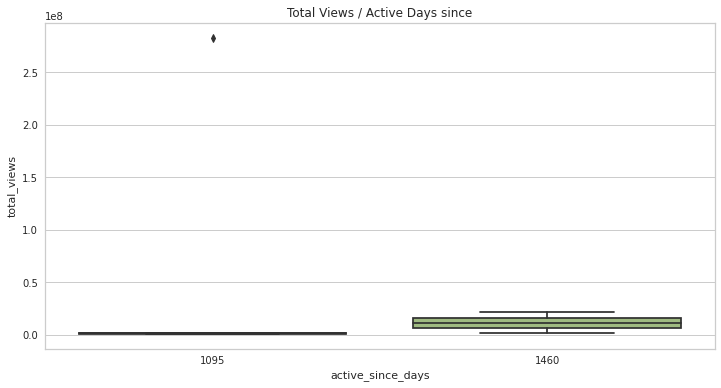

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Cluster",
       ylabel="Duration Seconds",
       title="Total Views / Active Days since")

ax = sns.boxplot(x= "active_since_days", y="total_views",
                 data=df[df.fortune > 0], ax = ax)

In [75]:
df.groupby('active_since_days')['total_views'].mean()

active_since_days
365    1890763.54
730    4572392.31
1095   6308246.07
1460   3945304.23
Name: total_views, dtype: float64

In [76]:
df[df.fortune > 0].groupby('active_since_days')['total_views'].mean()

active_since_days
1095   57294977.00
1460   11243765.00
Name: total_views, dtype: float64

In [70]:
df[df.save > 0].groupby('active_since_days')['total_views'].mean().iloc[3]

5798608.766666667

In [67]:
df[df.fortune > 0]

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_stopwords,avg_word_len,...,young,younger,youth,yummy,zero,zip,zone,сool,сrazy,cluster
2820,v=TOqctsP5jo8,40 life hacks that will save you a fortune,1095,960,439203,42,9,0,4,4.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3086,v=YgvLP1Rdkxs,30 cheap home repair hacks that will save you ...,1095,834,1496512,55,11,0,4,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3218,v=BZxpd82BqXI,30 smart everyday tips that will save you a fo...,1095,1020,432835,51,10,0,4,5.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3527,v=GzgDMV8sGfk,27 super easy diy clothing hacks that'll save ...,1095,1140,1075226,59,11,1,3,5.363636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3549,v=_9YMpuLDnwo,42 holy grail hacks that will save you a fortune,1095,1080,283031109,48,10,0,4,4.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4154,v=uuv-SqZgumk,16 life hacks that'll help you save a fortune,1460,960,1369195,45,9,1,3,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4377,v=ykiLeiOXTbE,11 cool life tips that will save you a fortune,1460,644,21118335,46,10,0,4,4.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


We don't know if some videos were promoted

Some tiltes used the letter 'l' as the character '|'